# guiding question:

What if we used a forward model to get exchange between substrate pools - and then calculated the probabilities for EVERY N2O production process based on the proportions of the substrates for that process? Like what's the probability of getting a 15NH2OH and a 15NO? Then we can add these to get the total production of 46N2O that we would expect from that combination of processes — and likewise for each of the other isotopomers as well.

# next:

- separate out rate constants for different steps in AOA ammonia oxidation pathway
- which version of the model best explains the data?

# initialization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# use for initialization
#from collections import namedtuple

# use for plotting interpolations of measured incubation data
#import scipy.interpolate as interp

# use for nelder-mead optimization of a convex function
from scipy.optimize import minimize
from numpy.random import rand

import scripts as sc # Python scripts containing helper functions

Set up the model:

In [2]:
### KEYWORDS ###
stn = "PS2"
ft = "Interface"
t = "NO2-"
bgckey = stn+ft

### INITIALIZATION ###

gridded_dataNH4, bgcNH4, isos, trNH4, params = sc.initialize(station=stn,
                                      feature=ft,
                                      tracer="NH4+")
gridded_dataNO2, bgcNO2, isos, trNO2, params = sc.initialize(station=stn,
                                      feature=ft,
                                      tracer="NO2-")
gridded_dataNO3, bgcNO3, isos, trNO3, params = sc.initialize(station=stn,
                                      feature=ft,
                                      tracer="NO3-")

### INITIAL GUESS FOR OPTIMIZATION ###
x0 = sc.x0(station=stn, feature=ft, key=bgckey)

[kestimateNH4, kestimateNO, kestimateNO2, kestimateNO3, kestimate_hybrid1,
 kestimate_hybrid2, kestimate_hybrid3, kestimate_hybrid4] = x0

estimated k for N2O production from NH4+: 4.9509772922495746e-08
estimated k for N2O production from NO3-: 2.599433902425462e-08
estimated k for N2O production from NO2-: 1.4246780715766207e-09
estimated k for N2O production from NO: 1.8479720770031943e-05
estimated k for hybrid pathway #1 from NH4+ & NO2-: 3.640687876109889e-08
estimated k for hybrid pathway #2 from NH4+ & NO2-: 2.938709760246231e-08
estimated k for hybrid pathway #1 from NH2OH & NO: 0.0001860693600254366
estimated k for hybrid pathway #2 from NH2OH & NO: 0.00015006077455405147


In [3]:
bgcNH4.kNH4TONO2

0.005257105287132567

# test models

In [4]:
x = [kestimateNH4, kestimateNO2, kestimateNO3, kestimate_hybrid1, kestimate_hybrid2]

tracers = sc.modelv1(x, bgcNH4, isos, trNH4, params)

print(sc.costfxn(trainingdata = gridded_dataNH4,
                modeled_44 = tracers.n2o_44,
                modeled_45a = tracers.n2o_45a,
                modeled_45b = tracers.n2o_45b,
                modeled_46 = tracers.n2o_46,
                weights = np.array([1,10,10,10])))

1.306881166445786


In [5]:
x = [kestimateNH4, kestimateNO, kestimateNO3, kestimate_hybrid3, kestimate_hybrid4]

tracers = sc.modelv3(x, bgcNH4, isos, trNH4, params)

print(sc.costfxn(trainingdata = gridded_dataNH4,
                modeled_44 = tracers.n2o_44,
                modeled_45a = tracers.n2o_45a,
                modeled_45b = tracers.n2o_45b,
                modeled_46 = tracers.n2o_46,
                weights = np.array([1,10,10,10])))

1.281535599918271


# optimization

In [19]:
def objective(x): #, bgc, isos, tracers, modelparams):
    
    tracersNH4 = sc.modelv3(x, bgcNH4, isos, trNH4, params)
    
    costNH4 = sc.costfxn(trainingdata = gridded_dataNH4,
                modeled_44 = tracers.n2o_44,
                modeled_45a = tracers.n2o_45a,
                modeled_45b = tracers.n2o_45b,
                modeled_46 = tracers.n2o_46,
                weights = np.array([0,10,10,100]))
    
    tracersNO2 = sc.modelv3(x, bgcNO2, isos, trNO2, params)
    
    costNO2 = sc.costfxn(trainingdata = gridded_dataNO2,
                modeled_44 = tracers.n2o_44,
                modeled_45a = tracers.n2o_45a,
                modeled_45b = tracers.n2o_45b,
                modeled_46 = tracers.n2o_46,
                weights = np.array([0,10,10,100]))
    
    tracersNO3 = sc.modelv3(x, bgcNO3, isos, trNO3, params)
    
    costNO3 = sc.costfxn(trainingdata = gridded_dataNO3,
                modeled_44 = tracers.n2o_44,
                modeled_45a = tracers.n2o_45a,
                modeled_45b = tracers.n2o_45b,
                modeled_46 = tracers.n2o_46,
                weights = np.array([0,10,10,100]))
    
    cost = costNH4 + costNO2 + costNO3
    
    return cost

In [87]:
def objective(x): #, bgc, isos, tracers, modelparams):
    
    tracers = sc.modelv3(x, bgcNH4, isos, trNH4, params)
    
    cost = sc.costfxn(trainingdata = gridded_dataNH4,
                modeled_44 = tracers.n2o_44,
                modeled_45a = tracers.n2o_45a,
                modeled_45b = tracers.n2o_45b,
                modeled_46 = tracers.n2o_46,
                weights = np.array([1,10,10,10]))
    
    return cost

In [20]:
#x = [kestimateNH4, kestimateNO2, kestimateNO3, kestimate_hybrid1, kestimate_hybrid2] # for modelv1

#x = [kestimateNH4, kestimateNO2, kestimateNO3, kestimate_hybrid1, kestimate_hybrid2] # for modelv2

x = [kestimateNH4, kestimateNO, kestimateNO3, kestimate_hybrid3, kestimate_hybrid4] # for modelv3

In [21]:
print(f"objective(x0)={objective(x):.3}") #, bgc, isos, tr, params):.3}")

objective(x0)=4.09


In [22]:
xguess = x

xguess

[4.9509772922495746e-08,
 1.8479720770031943e-05,
 2.599433902425462e-08,
 0.0001860693600254366,
 0.00015006077455405147]

In [23]:
# define bounds: no negative rate constants
bnds = ((0, None), (0, None), (0, None), (0, None), (0, None))

# perform the search with intelligently selected x0
#result = minimize(objective, x, args = (bgc, isos, tr, modelparams), method='nelder-mead', bounds=bnds)
result = minimize(objective, x, method='nelder-mead', bounds=bnds)
# summarize the result
print('Status : %s' % result['message'])
print('Total Evaluations: %d' % result['nfev'])
# evaluate solution
solution = result['x']
evaluation = objective(solution)#, bgc, isos, tr, params)
print('Solution: f(%s) = %.5f' % (solution, evaluation))

Status : Optimization terminated successfully.
Total Evaluations: 123
Solution: f([1.57690020e-07 7.01043606e-06 3.12410078e-08 9.23046145e-05
 1.10080133e-04]) = 2.72966


In [19]:
### OPTIMIZE WITH RANDOMLY SELECTED X0 ###

# define range for input
r_min = np.array(xguess)*0.75
r_max = np.array(xguess)*1.25
# define the starting point as a random sample from the domain
pt = r_min + rand(5)*(r_max - r_min)

pt

array([5.73260575e-08, 1.75606908e-05, 2.44042694e-08, 1.89016834e-03,
       1.35033416e-03])

In [20]:
# define bounds: no negative rate constants
bnds = ((0, None), (0, None), (0, None), (0, None), (0, None))

# perform the search with randomly selected x0
result = minimize(objective, pt, args = (bgc, isos, tr, modelparams), method='nelder-mead', bounds=bnds)
# summarize the result
print('Status : %s' % result['message'])
print('Total Evaluations: %d' % result['nfev'])
# evaluate solution
solution = result['x']
evaluation = objective(solution, bgc, isos, tr, modelparams)
print('Solution: f(%s) = %.5f' % (solution, evaluation))

Status : Optimization terminated successfully.
Total Evaluations: 131
Solution: f([5.65511704e-08 1.64422905e-05 3.59376658e-08 2.03772521e-03
 1.17240781e-03]) = 0.25161


In [24]:
objective(result.x)#, bgc, isos, tr, modelparams)

2.729663124529546

In [25]:
result.x

array([1.57690020e-07, 7.01043606e-06, 3.12410078e-08, 9.23046145e-05,
       1.10080133e-04])

# post-processing

In [26]:
tracersNH4 = sc.modelv3(result.x, bgcNH4, isos, trNH4, params)
tracersNO2 = sc.modelv3(result.x, bgcNO2, isos, trNO2, params)
tracersNO3 = sc.modelv3(result.x, bgcNO3, isos, trNO3, params)

In [27]:
outputNH4 = sc.postprocess(bgcNH4, isos, tracersNH4, result.x, model="modelv3")
outputNO2 = sc.postprocess(bgcNO2, isos, tracersNO2, result.x, model="modelv3")
outputNO3 = sc.postprocess(bgcNO3, isos, tracersNO3, result.x, model="modelv3")


Nit. (nM/day): 0.041164528847799184
Denit. from NO (nM/day): 0.0028274348859619676
Denit. from NO3- (nM/day): 20.509915700276107
Hybrid 1 (nM/day): 0.020620804517466375
Hybrid 2 (nM/day): 0.024591846374554197
Nit. (nM/day): 0.04115342039464466
Denit. from NO (nM/day): 0.023012257731949086
Denit. from NO3- (nM/day): 20.528240384838952
Hybrid 1 (nM/day): 0.056065284641369055
Hybrid 2 (nM/day): 0.06686203080381095
Nit. (nM/day): 0.04115342039464466
Denit. from NO (nM/day): 0.0028275923441847127
Denit. from NO3- (nM/day): 22.140671356591
Hybrid 1 (nM/day): 0.02068177400423196
Hybrid 2 (nM/day): 0.024664557031929598


In [28]:
print(outputNH4['check_mass_conservation'].min())
print(outputNH4['check_mass_conservation'].max())

27348.127762902175
27358.979392426336


<AxesSubplot:>

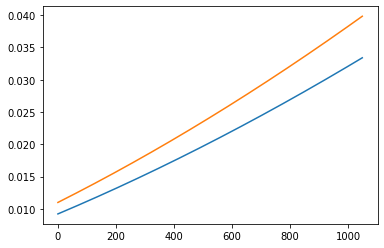

In [29]:
outputNH4.hybrid1.plot()
outputNH4.hybrid2.plot()

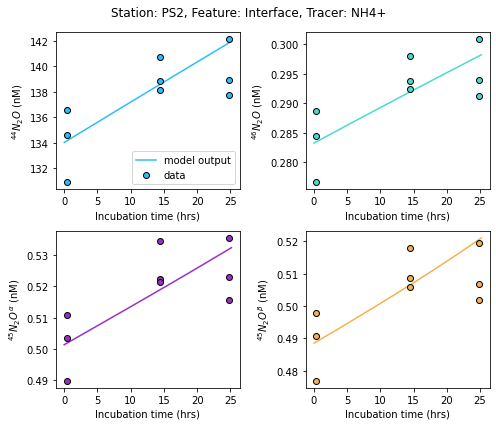

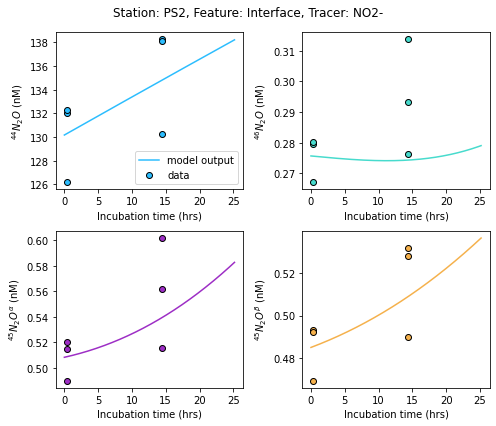

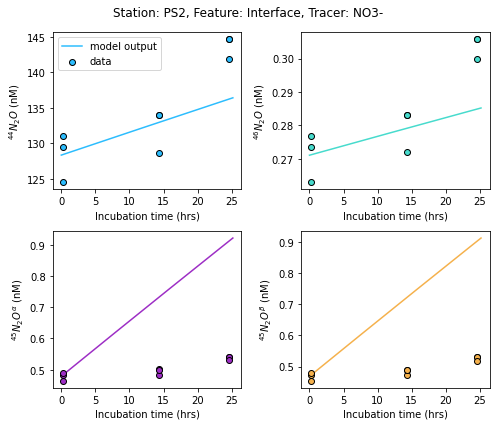

In [30]:
inputdata=pd.read_csv(f'{sc.datapath()}00_incubationdata.csv')

sc.scatter_plot(data=inputdata, station=stn, feature=ft, tracer="NH4+",
             modeloutput=outputNH4, filename=f"Figures/{stn}{ft}NH4+modelv3.pdf")

sc.scatter_plot(data=inputdata, station=stn, feature=ft, tracer="NO2-",
             modeloutput=outputNO2, filename=f"Figures/{stn}{ft}NO2-modelv3.pdf")

sc.scatter_plot(data=inputdata, station=stn, feature=ft, tracer="NO3-",
             modeloutput=outputNO3, filename=f"Figures/{stn}{ft}NO3-modelv3.pdf")


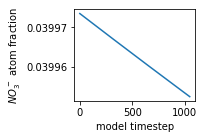

In [118]:
fig, ax = plt.subplots(1,1, figsize = (3,2))

ax.plot(outputNO3[['AFNO3-']])
ax.set_xlabel("model timestep")
ax.set_ylabel(r"$NO_3^-$ atom fraction")

plt.tight_layout()
#plt.savefig("figures/no3-atomfraction.pdf")

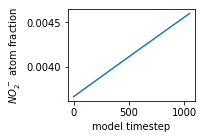

In [119]:
fig, ax = plt.subplots(1,1, figsize = (3,2))

ax.plot(outputNO3[['AFNO2-']])
ax.set_xlabel("model timestep")
ax.set_ylabel(r"$NO_2^-$ atom fraction")

plt.tight_layout()
#plt.savefig("figures/no2-atomfraction.pdf")

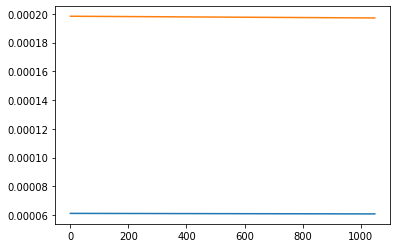

In [63]:
plt.plot(outputNH4['hybrid1'])
plt.plot(outputNH4['hybrid2'])